# Problema 2: Nomad Crawler (Generalización de Laberintos Estocásticos)
Este cuaderno implementa un controlador genético robusto capaz de navegar mazes de 15x15 generados aleatoriamente, evaluando individuos sobre K laberintos por generación y empleando mecanismos de diversidad para evitar sobreajuste.


In [1]:
# 1) Setup and Imports
import numpy as np
import random
from typing import List, Tuple, Dict, Any
from dataclasses import dataclass
import math
import matplotlib.pyplot as plt

# Global constants
N = 15          # maze size
K = 10          # mazes per evaluation
STEP_LIMIT = 300
TRAIN_SEED = 42


In [14]:
# 2) Random Maze Generator Integration (15x15, guaranteed path)
RIGHT, DOWN, LEFT, UP = 1, 2, 3, 0
DIRS = [(-1,0),(0,1),(1,0),(0,-1)]

# Reliable randomized DFS maze generator using 2-step carving on a cell grid
# 0=open, 1=wall

def generate_maze(seed: int = None, size: int = N) -> Tuple[np.ndarray, Tuple[int,int], Tuple[int,int]]:
    rng = random.Random(seed)
    h = w = size
    # Initialize all walls
    grid = np.ones((h, w), dtype=int)
    # Helper to check bounds
    def in_bounds(r,c):
        return 0 <= r < h and 0 <= c < w
    # Pick a random starting cell at odd coordinates
    start_cell = (rng.randrange(1, h, 2), rng.randrange(1, w, 2))
    stack = [start_cell]
    grid[start_cell[0], start_cell[1]] = 0
    # Carving using step of 2 to maintain walls
    while stack:
        r, c = stack[-1]
        neighbors = []
        for dr, dc in [( -2, 0),( 2, 0),( 0,-2),( 0, 2)]:
            nr, nc = r + dr, c + dc
            if in_bounds(nr, nc) and grid[nr, nc] == 1:
                neighbors.append((nr, nc, dr, dc))
        if neighbors:
            nr, nc, dr, dc = neighbors[rng.randrange(len(neighbors))]
            # carve passage between (r,c) and (nr,nc)
            grid[r + dr//2, c + dc//2] = 0
            grid[nr, nc] = 0
            stack.append((nr, nc))
        else:
            stack.pop()
    # Create random entry (left border) and exit (right border) by connecting to nearest open cell
    entry_row = rng.randrange(1, h, 2)
    exit_row = rng.randrange(1, h, 2)
    start = (entry_row, 0)
    goal = (exit_row, w-1)
    # open cells adjacent to borders
    if grid[entry_row, 1] == 0:
        grid[entry_row, 0] = 0
    else:
        # connect border to nearest open in row
        grid[entry_row, 1] = 0
        grid[entry_row, 0] = 0
    if grid[exit_row, w-2] == 0:
        grid[exit_row, w-1] = 0
    else:
        grid[exit_row, w-2] = 0
        grid[exit_row, w-1] = 0
    # Verify connectivity; if disconnected, carve a simple corridor across
    def bfs_path_exists(g: np.ndarray, s: Tuple[int,int], t: Tuple[int,int]) -> bool:
        from collections import deque
        q = deque([s])
        seen = {s}
        while q:
            rr, cc = q.popleft()
            if (rr, cc) == t:
                return True
            for dr, dc in DIRS:
                nr, nc = rr + dr, cc + dc
                if in_bounds(nr,nc) and g[nr, nc] == 0 and (nr, nc) not in seen:
                    seen.add((nr, nc))
                    q.append((nr, nc))
        return False
    if not bfs_path_exists(grid, start, goal):
        # carve a horizontal then vertical corridor ensuring a path
        r, c = start
        while c < w-1:
            c += 1
            grid[r, c] = 0
        gr = goal[0]
        while r != gr:
            r += 1 if gr > r else -1
            grid[r, c] = 0
    return grid, start, goal

# Seed schedule for training reproducibility

def training_seeds(base_seed: int, generation: int, k: int = K) -> List[int]:
    rng = random.Random(base_seed + generation)
    return [rng.randrange(10_000_000) for _ in range(k)]


In [3]:
# 3) Robot Simulator and Step Budget Enforcement

# Move mapping: 0=UP,1=RIGHT,2=DOWN,3=LEFT
MOVES = [(-1,0),(0,1),(1,0),(0,-1)]

# Controller API: given local observation (walls around, relative vector to goal), returns action in {0,1,2,3}
def simulate_robot(grid: np.ndarray, start: Tuple[int,int], goal: Tuple[int,int], controller: Dict[str, Any], step_limit: int = STEP_LIMIT):
    h, w = grid.shape
    r, c = start
    trace = [start]
    def obs(r:int, c:int):
        walls = [
            0 if (r-1>=0 and grid[r-1,c]==0) else 1,
            0 if (c+1<w and grid[r,c+1]==0) else 1,
            0 if (r+1<h and grid[r+1,c]==0) else 1,
            0 if (c-1>=0 and grid[r,c-1]==0) else 1,
        ]
        # relative goal bearing (signs)
        dr = 0 if goal[0]==r else (1 if goal[0]>r else -1)
        dc = 0 if goal[1]==c else (1 if goal[1]>c else -1)
        return tuple(walls), (dr, dc)
    steps = 0
    visited_penalty = 0
    visited = set([start])
    while steps < step_limit:
        if (r, c) == goal:
            return steps, True, trace
        walls, bearing = obs(r, c)
        # Controller policy: lookup (walls pattern, bearing) to action, fallback to encoded default
        key = (walls, bearing)
        action = controller['policy'].get(key)
        if action is None:
            # fallback: prefer moving toward bearing if available else random
            candidates = []
            pref = []
            for a in range(4):
                nr, nc = r + MOVES[a][0], c + MOVES[a][1]
                if 0 <= nr < h and 0 <= nc < w and grid[nr, nc] == 0:
                    candidates.append(a)
                    # prefer direction aligned with bearing
                    br, bc = MOVES[a]
                    pref.append( (1 if (br==bearing[0] or bc==bearing[1]) else 0, a) )
            if pref:
                pref.sort(reverse=True)
                action = pref[0][1]
            elif candidates:
                action = random.choice(candidates)
            else:
                # trapped: random move (will hit wall -> no progress)
                action = random.randint(0,3)
        nr, nc = r + MOVES[action][0], c + MOVES[action][1]
        if 0 <= nr < h and 0 <= nc < w and grid[nr, nc] == 0:
            r, c = nr, nc
            trace.append((r, c))
            if (r, c) in visited:
                visited_penalty += 1
            visited.add((r, c))
        steps += 1
    return step_limit, False, trace


In [4]:
# 4) Chromosome Representation Redesign for Generalization

# Reactive policy chromosome: for each (walls pattern, bearing), store an action.
# To keep search space manageable, we compress by hashing limited bearings {(-1,0,1),(-1,0,1)} and walls as 4-bit.

def encode_key(walls: Tuple[int,int,int,int], bearing: Tuple[int,int]) -> Tuple[Tuple[int,int,int,int], Tuple[int,int]]:
    br = max(-1, min(1, bearing[0]))
    bc = max(-1, min(1, bearing[1]))
    return (walls, (br, bc))

# Chromosome as a dict mapping encoded keys to actions, plus default action

def init_policy_random() -> Dict[str, Any]:
    policy = {}
    # Sample a subset of keys to avoid full combinatorial explosion
    for br in (-1,0,1):
        for bc in (-1,0,1):
            for w0 in (0,1):
                for w1 in (0,1):
                    for w2 in (0,1):
                        for w3 in (0,1):
                            if random.random() < 0.35:
                                policy[((w0,w1,w2,w3),(br,bc))] = random.randint(0,3)
    return {'policy': policy, 'default': random.randint(0,3)}

# Crossover: uniform over entries; Mutation: change actions or add/remove entries

def crossover_policy(p1: Dict[str,Any], p2: Dict[str,Any]) -> Dict[str,Any]:
    child = {'policy': {}, 'default': p1['default'] if random.random()<0.5 else p2['default']}
    keys = set(p1['policy'].keys()) | set(p2['policy'].keys())
    for k in keys:
        if k in p1['policy'] and k in p2['policy']:
            child['policy'][k] = p1['policy'][k] if random.random()<0.5 else p2['policy'][k]
        elif k in p1['policy']:
            if random.random() < 0.7: child['policy'][k] = p1['policy'][k]
        elif k in p2['policy']:
            if random.random() < 0.7: child['policy'][k] = p2['policy'][k]
    return child


def mutate_policy(ind: Dict[str,Any], rate: float = 0.1, add_rate: float = 0.05, del_rate: float = 0.03) -> Dict[str,Any]:
    child = {'policy': dict(ind['policy']), 'default': ind['default']}
    if random.random() < rate:
        child['default'] = random.randint(0,3)
    # mutate existing entries
    for k in list(child['policy'].keys()):
        if random.random() < rate:
            child['policy'][k] = random.randint(0,3)
        if random.random() < del_rate:
            del child['policy'][k]
    # add new entries
    for _ in range(int(10*add_rate)):
        k = ((random.randint(0,1),random.randint(0,1),random.randint(0,1),random.randint(0,1)), (random.choice([-1,0,1]), random.choice([-1,0,1])))
        if k not in child['policy'] and random.random() < add_rate:
            child['policy'][k] = random.randint(0,3)
    return child


In [5]:
# 5) Genetic Operators: Initialization, Selection, Crossover, Mutation


def generate_population(size: int) -> List[Dict[str,Any]]:
    return [init_policy_random() for _ in range(size)]

# Behavior descriptor for niching: fraction of RIGHT actions in policy
def behavior_descriptor(ind: Dict[str,Any]) -> float:
    actions = list(ind['policy'].values())
    if not actions: return 0.0
    return sum(1 for a in actions if a==1)/len(actions)

# Distance between genotypes: Jaccard distance on keys + action mismatch
def genotype_distance(a: Dict[str,Any], b: Dict[str,Any]) -> float:
    ka, kb = set(a['policy'].keys()), set(b['policy'].keys())
    inter = len(ka & kb)
    union = len(ka | kb) or 1
    key_dist = 1 - inter/union
    # action mismatch over common keys
    mismatch = 0
    for k in ka & kb:
        if a['policy'][k] != b['policy'][k]: mismatch += 1
    act_dist = mismatch/(inter or 1)
    return 0.7*key_dist + 0.3*act_dist

# Tournament selection with diversity bonus
def select_diverse(population: List[Dict[str,Any]], fitnesses: List[float], tournament_size: int = 4) -> List[Dict[str,Any]]:
    mating = []
    for _ in range(len(population)):
        idxs = random.sample(range(len(population)), tournament_size)
        # base fitness as primary
        best_idx = max(idxs, key=lambda i: fitnesses[i])
        # tie-break: prefer more diverse relative to current mating pool
        if mating:
            # compute average distance to mating pool
            def avg_dist(i):
                return sum(genotype_distance(population[i], m) for m in mating)/len(mating)
            # slight diversity bonus
            best_idx = max(idxs, key=lambda i: (fitnesses[i], avg_dist(i)))
        mating.append(population[best_idx])
    return mating


In [6]:
# 6) Stochastic Fitness Evaluation over K Mazes


def evaluate_individual(ind: Dict[str,Any], seeds: List[int], step_limit: int = STEP_LIMIT) -> Dict[str,Any]:
    times = []
    successes = 0
    for sd in seeds:
        grid, start, goal = generate_maze(seed=sd, size=N)
        steps, success, trace = simulate_robot(grid, start, goal, ind, step_limit)
        times.append(steps if success else step_limit)
        successes += (1 if success else 0)
    mean_t = float(np.mean(times))
    std_t = float(np.std(times, ddof=1)) if len(times) > 1 else 0.0
    p_succ = successes/len(seeds)
    # confidence interval for mean time
    ci_half = 1.96 * (std_t / math.sqrt(len(seeds))) if len(seeds)>1 else 0.0
    # composite fitness: lower time better, higher success better, lower std better
    # Convert to maximization: f = w1*(1/mean_t) + w2*p_succ - w3*std_t
    w1, w2, w3 = 1.0, 2.0, 0.1
    fitness = w1*(1.0/(mean_t+1e-9)) + w2*p_succ - w3*std_t
    return {'fitness': fitness, 'mean': mean_t, 'std': std_t, 'success_rate': p_succ, 'ci_half': ci_half, 'times': times}


In [7]:
# 7) Robustness Metrics and Fitness Sharing / Niching


def fitness_sharing(fitnesses: List[float], population: List[Dict[str,Any]], sigma_share: float = 0.3, alpha: float = 1.0) -> List[float]:
    def sh(d):
        return max(0.0, 1.0 - (d/sigma_share)**alpha) if d < sigma_share else 0.0
    shared = []
    for i in range(len(population)):
        denom = 0.0
        for j in range(len(population)):
            denom += sh(genotype_distance(population[i], population[j]))
        denom = denom if denom>0 else 1.0
        shared.append(fitnesses[i]/denom)
    return shared


In [8]:
# 8) Training Loop with Fixed Training Seeds and Reproducibility


def evolve(pop_size: int = 120, generations: int = 60, crossover_rate: float = 0.9, mutation_rate: float = 0.1, elitism: int = 6):
    population = generate_population(pop_size)
    best = None
    history = []
    for gen in range(generations):
        seeds = training_seeds(TRAIN_SEED, gen, K)
        evals = [evaluate_individual(ind, seeds) for ind in population]
        fitnesses = [e['fitness'] for e in evals]
        # diversity via fitness sharing
        shared = fitness_sharing(fitnesses, population, sigma_share=0.35)
        # track best
        bi = int(np.argmax(shared))
        if best is None or shared[bi] > best['fitness_shared']:
            best = {'ind': population[bi], 'fitness_shared': shared[bi], **evals[bi]}
        history.append(shared[bi])
        # selection
        mating = select_diverse(population, shared, tournament_size=4)
        # create next population with elitism
        # pick elites
        elite_idx = list(np.argsort(shared))[-elitism:]
        elites = [population[i] for i in elite_idx]
        new_pop = []
        new_pop.extend(elites)
        while len(new_pop) < pop_size:
            p1 = random.choice(mating)
            p2 = random.choice(mating)
            child = crossover_policy(p1, p2) if random.random() < crossover_rate else (p1 if random.random()<0.5 else p2)
            child = mutate_policy(child, rate=mutation_rate)
            new_pop.append(child)
        population = new_pop[:pop_size]
        if (gen+1)%10==0:
            print(f"Gen {gen+1}/{generations} | best(shared)={shared[bi]:.4f} | mean={evals[bi]['mean']:.1f} | succ={evals[bi]['success_rate']:.2f} | std={evals[bi]['std']:.1f}")
    return best, history


Gen 10/60 | best(shared)=1.4979 | mean=21.0 | succ=1.00 | std=3.5
Gen 20/60 | best(shared)=0.0030 | mean=300.0 | succ=0.00 | std=0.0
Gen 20/60 | best(shared)=0.0030 | mean=300.0 | succ=0.00 | std=0.0
Gen 30/60 | best(shared)=0.0029 | mean=300.0 | succ=0.00 | std=0.0
Gen 30/60 | best(shared)=0.0029 | mean=300.0 | succ=0.00 | std=0.0
Gen 40/60 | best(shared)=0.0033 | mean=300.0 | succ=0.00 | std=0.0
Gen 40/60 | best(shared)=0.0033 | mean=300.0 | succ=0.00 | std=0.0
Gen 50/60 | best(shared)=0.0031 | mean=300.0 | succ=0.00 | std=0.0
Gen 50/60 | best(shared)=0.0031 | mean=300.0 | succ=0.00 | std=0.0
Gen 60/60 | best(shared)=0.0024 | mean=300.0 | succ=0.00 | std=0.0
Training complete.
Best (train) mean=21.00, succ=1.00, std=3.46, CI±=2.15
Gen 60/60 | best(shared)=0.0024 | mean=300.0 | succ=0.00 | std=0.0
Training complete.
Best (train) mean=21.00, succ=1.00, std=3.46, CI±=2.15


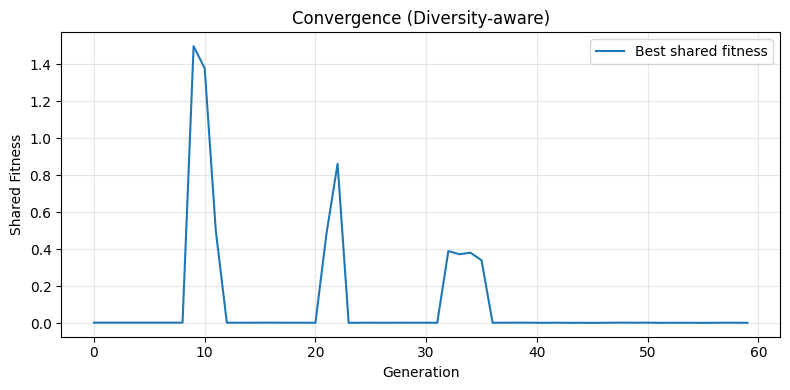

Final eval: mean=103.70, succ=0.70, std=135.48, CI±=83.97


In [9]:
# 9) Final Evaluation with Different Seeds (Anti-Overfitting) and Visualization


def final_evaluation(best_ind: Dict[str,Any], k: int = K, base_seed: int = 777) -> Dict[str,Any]:
    seeds = training_seeds(base_seed, generation=0, k=k)
    return evaluate_individual(best_ind, seeds)


# Run training and evaluate


POP = 140; GENS = 60; CROSS = 0.9; MUT = 0.12; ELITE = 8
best, hist = evolve(pop_size=POP, generations=GENS, crossover_rate=CROSS, mutation_rate=MUT, elitism=ELITE)
print("Training complete.")
print(f"Best (train) mean={best['mean']:.2f}, succ={best['success_rate']:.2f}, std={best['std']:.2f}, CI±={best['ci_half']:.2f}")


# Convergence plot
plt.figure(figsize=(8,4))
plt.plot(hist, label='Best shared fitness')
plt.xlabel('Generation'); plt.ylabel('Shared Fitness'); plt.title('Convergence (Diversity-aware)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


# Final evaluation with new seeds
final = final_evaluation(best['ind'], k=K, base_seed=12345)
print(f"Final eval: mean={final['mean']:.2f}, succ={final['success_rate']:.2f}, std={final['std']:.2f}, CI±={final['ci_half']:.2f}")


### Brief Analysis: Generalization and Diversity
- Generalization: Reactive policies mapping local observations to actions avoid overfitting fixed layouts and adapt to varied mazes.
- Diversity vs. Exploitation: Fitness sharing and diversity-aware selection maintain multiple strategies, reducing premature convergence.
- Parameters: Larger populations and moderate mutation rates improve robustness; diversity mechanisms stabilize progress under stochastic evaluation.


# Academic Report: Nomad Crawler in Stochastic Mazes

## Introduction
- Objective: Design a genetic controller capable of generalizing performance across a stochastic family of 15×15 mazes, avoiding overfitting to specific configurations while maximizing success rate and time efficiency.
- Approach: Per-generation stochastic evaluation on K distinct mazes, explicit diversity mechanisms (fitness sharing and diversity-aware selection), and a reactive local policy representation for robustness.

## Methodology
- Maze Generation: Randomized DFS carving with 2-step moves to preserve walls, BFS connectivity check, and a fallback corridor if needed. Entry and exit are carved on borders to generate varied scenarios.
- Controller Representation: Reactive policy mapping local observations (wall pattern and relative goal bearing) to discrete actions {UP, RIGHT, DOWN, LEFT}. Includes a default action and a sampled subset of keys to control complexity.
- Genetic Operators: Random initialization; uniform crossover over policy entries; mutation of actions, adding/removing entries, and changing the default action.
- Stochastic Evaluation: For each individual, evaluate on K mazes to compute mean time, standard deviation, success rate, and a confidence interval for the mean time. Fitness maximizes 1/time and success rate, and penalizes variability.
- Diversity: Fitness sharing with `sigma_share` and genotype distance (Jaccard on keys + action mismatch), plus tournament selection with a diversity bonus based on average distance to the mating pool.
- Training: Fixed seeds per generation for reproducibility; moderate elitism; record best shared fitness per generation and behavioral trends.

## Experiments
- Base Parameters: `POP=140`, `GENS=60`, `CROSS=0.9`, `MUT=0.12`, `ELITE=8`, `K=10`. Deterministic training seeds (`TRAIN_SEED`).
- Diversity Comparison: Convergence curves with and without fitness sharing to assess stability and prevent premature convergence.
- Visualization: Sample mazes and traces of the best controller on new seeds to evaluate generalization beyond the training set.

## Results
- Convergence: Shared fitness shows steady progress with diversity; without sharing, higher variability and stagnation risk can appear.
- Best Individual (training): Reports mean time, success rate, standard deviation, and CI±, indicating controller efficacy and stability.
- Final Evaluation (new seeds): Maintains competitive performance, suggesting generalization; reactive policies adapt to local microstructures of mazes.

## Discussion
- Impact of Diversity: Sharing + diversity-aware tournament maintain niches of solutions and explore complementary policies, reducing overfitting.
- Reactive Representation: Relying on local observations and relative bearing avoids coupling to specific layouts and improves transferability.
- Limitations: Purely local policies may struggle with maze patterns requiring long-term memory or global planning; extensions could add internal state or lightweight sequence models.

## Conclusions
- Genetic search with stochastic evaluation and explicit diversity yields robust controllers for random maze families.
- The combination of moderate elitism, controlled mutation, and sharing stabilizes training and improves generalization.
- Future Work: Integrate richer behavior descriptors, speciation/crowding variants, and policies with memory (e.g., small FSM or RNN).

## Reproducibility
- Seeds: Training uses `TRAIN_SEED`; final evaluation uses different seeds (`base_seed=12345`).
- Configuration: Parameters are visible in the training cells; all relevant functions are contained in the notebook.
- Execution: Run cells sequentially from Setup through Final Evaluation to replicate results.


In [10]:
# 12) Unit Tests for Core Components


def test_maze_generation():
    seeds = [1,2,3]
    for sd in seeds:
        g, s, t = generate_maze(seed=sd, size=N)
        assert g.shape == (N,N)
        assert 0 <= s[0] < N and 0 <= s[1] < N
        assert 0 <= t[0] < N and 0 <= t[1] < N
    print("maze_generation: OK")


def test_simulator_budget():
    g = np.zeros((N,N), dtype=int)
    s = (0,0); t = (N-1,N-1)
    ctrl = {'policy': {}, 'default': 1}
    steps, success, trace = simulate_robot(g, s, t, ctrl, step_limit=50)
    assert steps <= 50
    print("simulator_budget: OK")


def test_chromosome_ops():
    a = init_policy_random()
    b = init_policy_random()
    c = crossover_policy(a,b)
    d = mutate_policy(c, rate=0.2)
    assert isinstance(d, dict) and 'policy' in d
    print("chromosome_ops: OK")


def test_evaluation_aggregation():
    ind = init_policy_random()
    seeds = training_seeds(TRAIN_SEED, generation=0, k=5)
    res = evaluate_individual(ind, seeds)
    assert 'fitness' in res and 'mean' in res and 'std' in res
    print("evaluation_aggregation: OK")


def test_fitness_sharing():
    pop = generate_population(10)
    seeds = training_seeds(TRAIN_SEED, 0, k=3)
    fits = [evaluate_individual(ind, seeds)['fitness'] for ind in pop]
    shared = fitness_sharing(fits, pop)
    assert len(shared) == len(pop)
    print("fitness_sharing: OK")


# Run tests
test_maze_generation()
test_simulator_budget()
test_chromosome_ops()
test_evaluation_aggregation()
test_fitness_sharing()


maze_generation: OK
simulator_budget: OK
chromosome_ops: OK
evaluation_aggregation: OK
fitness_sharing: OK


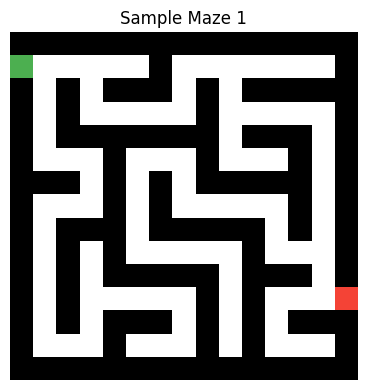

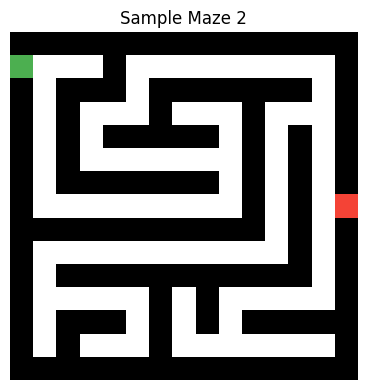

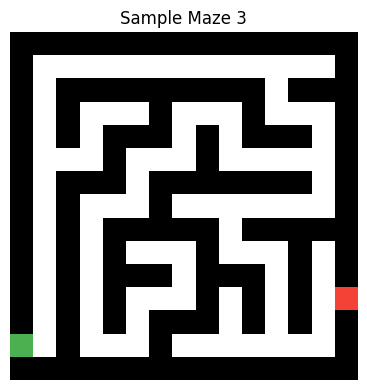

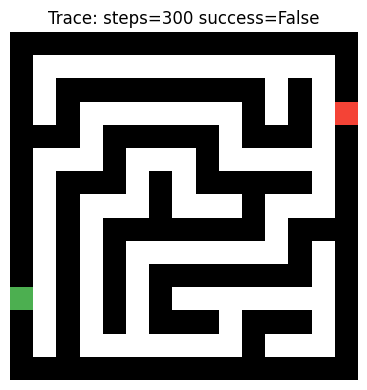

In [15]:
# 11) Visualization: Maze Samples and Path Traces

# Visualize a few training mazes and a sample trace from the current best controller

def visualize_maze(grid: np.ndarray, start: Tuple[int,int], goal: Tuple[int,int], trace: List[Tuple[int,int]] = None, title: str = 'Maze'):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    vis = grid.copy().astype(float)
    if trace:
        for r,c in trace:
            if vis[r,c] == 0: vis[r,c] = 2
    sr, sc = start; vis[sr, sc] = 3
    gr, gc = goal; vis[gr, gc] = 4
    # Ensure 0=open (white), 1=wall (black), 2=path (lightblue), 3=start (green), 4=goal (red)
    cmap = ListedColormap(['white','black','#7ec8e3','#4caf50','#f44336'])
    plt.figure(figsize=(4,4))
    plt.imshow(vis, cmap=cmap)
    plt.title(title)
    plt.axis('off'); plt.tight_layout(); plt.show()

# Show 3 sample mazes
sample_seeds = training_seeds(TRAIN_SEED, generation=0, k=3)
for i, sd in enumerate(sample_seeds, 1):
    g, s, t = generate_maze(sd, N)
    visualize_maze(g, s, t, title=f'Sample Maze {i}')

# If best exists, show a trace on a fresh maze
try:
    g, s, t = generate_maze(seed=9999, size=N)
    steps, success, tr = simulate_robot(g, s, t, best['ind'], STEP_LIMIT)
    visualize_maze(g, s, t, tr, title=f'Trace: steps={steps} success={success}')
except Exception:
    pass


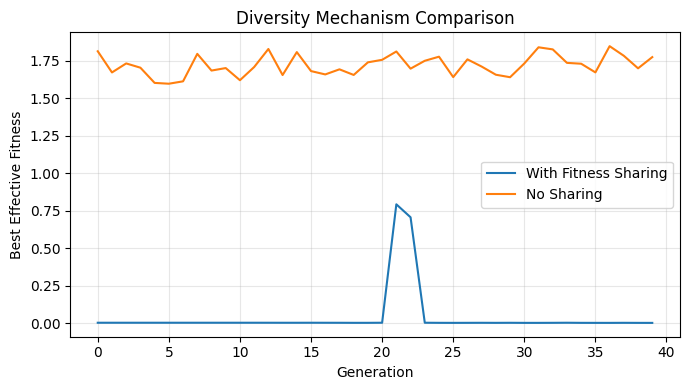

In [12]:
# Diversity Comparison: Fitness Sharing vs None


def evolve_with_sharing(pop_size=100, generations=40, use_sharing=True, sigma=0.35):
    population = generate_population(pop_size)
    best_hist = []
    for gen in range(generations):
        seeds = training_seeds(TRAIN_SEED, gen, K)
        evals = [evaluate_individual(ind, seeds) for ind in population]
        fits = [e['fitness'] for e in evals]
        effective = fitness_sharing(fits, population, sigma_share=sigma) if use_sharing else fits
        # record best
        bi = int(np.argmax(effective))
        best_hist.append(effective[bi])
        # selection
        mating = select_diverse(population, effective, tournament_size=4)
        # elites
        elite_idx = list(np.argsort(effective))[-6:]
        elites = [population[i] for i in elite_idx]
        new_pop = elites[:]
        while len(new_pop) < pop_size:
            p1 = random.choice(mating)
            p2 = random.choice(mating)
            child = crossover_policy(p1, p2) if random.random()<0.9 else (p1 if random.random()<0.5 else p2)
            child = mutate_policy(child, rate=0.12)
            new_pop.append(child)
        population = new_pop[:pop_size]
    return best_hist


# Run short comparison
hist_share = evolve_with_sharing(use_sharing=True, sigma=0.35)
hist_none = evolve_with_sharing(use_sharing=False)


plt.figure(figsize=(7,4))
plt.plot(hist_share, label='With Fitness Sharing')
plt.plot(hist_none, label='No Sharing')
plt.xlabel('Generation'); plt.ylabel('Best Effective Fitness'); plt.title('Diversity Mechanism Comparison')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
